# Building 3 neural networks to classify spam messages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Text processing
import tensorflow as tf # conda install -c conda-forge tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Deep learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D #CNN specific

In [2]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection"
messages = pd.read_csv(url, sep ='\t', names=["label", "message"])
messages = messages.drop_duplicates()

#Oversampled + Original copy of spam
url2 = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/BacktranslatedSpam"
new_spam = pd.read_csv(url2, sep ='\t', names=["message"]) # No label like the usual file here
spam_labels = ["spam" for i in range(len(new_spam))]
new_spam.insert(0, "label", spam_labels, allow_duplicates=True)

In [3]:
ham_msg = messages[messages.label =='ham']
print(len(ham_msg), len(new_spam))

4516 4571


In [4]:
new_spam_df = new_spam.sample(n = len(ham_msg), random_state = 754)
msg_df = pd.concat([ham_msg, new_spam_df])
msg_df.reset_index(drop=True)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...
...,...,...
9027,spam,"<Redirected from 21870000>Hello, this is your..."
9028,spam,don't know you and you don't know me. Send CH...
9029,spam,"You can stop more club tones by answering ""ST..."
9030,spam,"Latest news! Police station toilet stolen, po..."


In [5]:
msg_labels = (msg_df['label'].map({'ham': 0, 'spam': 1})).values
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],
                                                                  msg_labels,
                                                                  test_size=0.2,
                                                                  random_state=705)

In [6]:
#Tokenizer : turn words into integers
oov_tok = "<OOV>" # What to replace words that are not in the vocabulary with
vocab_size = 1000 # Maximum number of uniques words for tokenizer

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level=False, # Work words by word
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

# Discussion of hyper parameters of tokenizer
vocab_size equal to 500 means we drop 30% of the words in total (counting duplicates)

vocab_size equal to 1000 means we drop 20% of the words in total


When it comes to length of sentences, with a max_len of 50 we get more than 99.2% of the sentences, which makes it sufficiently long.

In [7]:
word_index = tokenizer.word_index
len(word_index)

8863

In [8]:
# Sequencing and padding on training and testing 
max_len = 50 # Max number of tokens, used with truncating and padding
trunc_type = "post" # Truncates sequences of tokens that are longer than max_len, post=right side
padding_type = "post" # Pads AFTER (with post) if sequence is shorter than max_len

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               padding = padding_type, truncating = trunc_type)

In [9]:
print(np.max(training_padded)) #We have 1000 words, INCLUDING the token 0 for padding and <OOV> for out of vocabulary
print(np.max(testing_padded))

999
999


In [10]:
print('Shape of training array: ', training_padded.shape)
print('Shape of testing array: ', testing_padded.shape)
print(type(training_padded))
print(type(train_labels))

Shape of training array:  (7225, 50)
Shape of testing array:  (1807, 50)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
#F1 score is not defined in Keras
#From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Keras functions to define neural network
Embedding layer takes as input a vector of length *input_length* of **integers**, where the integers are between 0 and *vocab_size-1* (both bounds included). The output is a matrix of dimensions *input_length* * *output_dim*. In other words, each input neuron is projected into a space of dimension *output_dim*.

The flatten layer flattens the 2D output into a 1D array

Dense layer is another name for the regular fully connected layer.

In [12]:
#vocab_size = 1000
#max_len = 50
embedding_dim = 32
batch_size = 20
fc_size = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model.add(Flatten())
model.add(Dense(fc_size, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            32000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 237,057
Trainable params: 237,057
Non-trainable params: 0
_________________________________________________________________


In [13]:
hist = model.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=15, batch_size=batch_size)

Epoch 1/15
362/362 [==============================] - 3s 4ms/step - loss: 0.1575 - accuracy: 0.9433 - precision_m: 0.9528 - recall_m: 0.9360 - f1_m: 0.9413 - val_loss: 0.0429 - val_accuracy: 0.9834 - val_precision_m: 0.9890 - val_recall_m: 0.9801 - val_f1_m: 0.9838
Epoch 2/15
362/362 [==============================] - 1s 3ms/step - loss: 0.0225 - accuracy: 0.9929 - precision_m: 0.9945 - recall_m: 0.9912 - f1_m: 0.9925 - val_loss: 0.0271 - val_accuracy: 0.9917 - val_precision_m: 0.9941 - val_recall_m: 0.9886 - val_f1_m: 0.9910
Epoch 3/15
362/362 [==============================] - 1s 3ms/step - loss: 0.0074 - accuracy: 0.9986 - precision_m: 0.9968 - recall_m: 0.9950 - f1_m: 0.9958 - val_loss: 0.0232 - val_accuracy: 0.9917 - val_precision_m: 0.9929 - val_recall_m: 0.9897 - val_f1_m: 0.9909
Epoch 4/15
362/362 [==============================] - 1s 3ms/step - loss: 0.0032 - accuracy: 0.9994 - precision_m: 0.9970 - recall_m: 0.9964 - f1_m: 0.9966 - val_loss: 0.0356 - val_accuracy: 0.9878 - va

In [14]:
loss, accuracy, precision, recall, f1_score = model.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9911455512046814 0.988258421421051 0.9927989840507507 0.9903088212013245


## Commenting on results
This new neural network performs significantly better.
It's difficult to say whether it's due to simply using more parameters or the embedding layer, but the results are there.

**Might be worth checking whether the choices of hyperparameters make sense**. Max_len and vocab_size might no longer be appropriate for this new dataset.

# Convolutional neural network
Trying out another technique to see if we can improve our model

In [15]:
#vocab_size = 1000
#max_len = 50
embedding_dim = 32
batch_size = 20

conv1_size = 32
fc_size = 64 

In [39]:
CNN = Sequential()
CNN.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
# No flatten because Conv1D input is formatted this way
CNN.add(Conv1D(conv1_size, 3, activation='relu'))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(Flatten())
CNN.add(Dense(fc_size, activation='relu'))
CNN.add(Dense(1, activation='sigmoid'))
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 48, 32)            3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                49216     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 84,385
Trainable params: 84,385
Non-trainable params: 0
__________________________________________________

In [40]:
histCNN = CNN.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=15, batch_size=batch_size)

Epoch 1/15
362/362 [==============================] - 3s 4ms/step - loss: 0.1580 - accuracy: 0.9384 - precision_m: 0.9431 - recall_m: 0.9335 - f1_m: 0.9346 - val_loss: 0.0531 - val_accuracy: 0.9845 - val_precision_m: 0.9884 - val_recall_m: 0.9813 - val_f1_m: 0.9843
Epoch 2/15
362/362 [==============================] - 1s 3ms/step - loss: 0.0328 - accuracy: 0.9909 - precision_m: 0.9947 - recall_m: 0.9865 - f1_m: 0.9901 - val_loss: 0.0354 - val_accuracy: 0.9889 - val_precision_m: 0.9970 - val_recall_m: 0.9814 - val_f1_m: 0.9886
Epoch 3/15
362/362 [==============================] - 1s 3ms/step - loss: 0.0135 - accuracy: 0.9961 - precision_m: 0.9976 - recall_m: 0.9945 - f1_m: 0.9958 - val_loss: 0.0271 - val_accuracy: 0.9934 - val_precision_m: 0.9943 - val_recall_m: 0.9939 - val_f1_m: 0.9938
Epoch 4/15
362/362 [==============================] - 1s 3ms/step - loss: 0.0048 - accuracy: 0.9989 - precision_m: 0.9997 - recall_m: 0.9984 - f1_m: 0.9990 - val_loss: 0.0282 - val_accuracy: 0.9928 - va

In [41]:
loss, accuracy, precision, recall, f1_score = CNN.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9928057789802551 0.9944339394569397 0.9920064210891724 0.9930518865585327


# Results
We obtain pretty similar results, very slightly better. Let's try more convolutional and pooling and less fully connected.

# Second convolutional network
More convolutional layers
More dense layers
Dropout in the dense layers

In [19]:
conv1_size = 32
conv2_size = 48
fc1_size = 48
dropout_rate1 = 0.2
fc2_size = 24
dropout_rate2 = 0.3

In [20]:
CNN2 = Sequential()
CNN2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
CNN2.add(Conv1D(conv1_size, 3, activation='relu'))
CNN2.add(MaxPooling1D(pool_size=2))
CNN2.add(Conv1D(conv2_size, 3, activation='relu'))
CNN2.add(MaxPooling1D(pool_size=2))
CNN2.add(Flatten())
CNN2.add(Dropout(dropout_rate1))
CNN2.add(Dense(fc1_size, activation='relu'))
CNN2.add(Dropout(dropout_rate2))
CNN2.add(Dense(fc2_size, activation='relu'))
CNN2.add(Dense(1, activation='sigmoid'))
CNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
CNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 48)            4656      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 48)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 528)               0         
_________________________________________________________________
dropout (Dropout)            (None, 528)              

In [21]:
histCNN2 = CNN2.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=15, batch_size=batch_size)

Epoch 1/15
362/362 [==============================] - 3s 6ms/step - loss: 0.2113 - accuracy: 0.9020 - precision_m: 0.8649 - recall_m: 0.8479 - f1_m: 0.8498 - val_loss: 0.0593 - val_accuracy: 0.9873 - val_precision_m: 0.9946 - val_recall_m: 0.9813 - val_f1_m: 0.9871
Epoch 2/15
362/362 [==============================] - 2s 4ms/step - loss: 0.0437 - accuracy: 0.9866 - precision_m: 0.9880 - recall_m: 0.9856 - f1_m: 0.9860 - val_loss: 0.0505 - val_accuracy: 0.9812 - val_precision_m: 0.9857 - val_recall_m: 0.9788 - val_f1_m: 0.9814
Epoch 3/15
362/362 [==============================] - 2s 4ms/step - loss: 0.0254 - accuracy: 0.9934 - precision_m: 0.9953 - recall_m: 0.9918 - f1_m: 0.9932 - val_loss: 0.0416 - val_accuracy: 0.9884 - val_precision_m: 0.9831 - val_recall_m: 0.9956 - val_f1_m: 0.9888
Epoch 4/15
362/362 [==============================] - 2s 4ms/step - loss: 0.0187 - accuracy: 0.9949 - precision_m: 0.9960 - recall_m: 0.9936 - f1_m: 0.9944 - val_loss: 0.0534 - val_accuracy: 0.9840 - va

In [22]:
loss, accuracy, precision, recall, f1_score = CNN2.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9939125776290894 0.9933026432991028 0.9950600266456604 0.9940406680107117


# Results of 2nd CNN
Slightly worse results.

# Potential improvements for all models
Have a fixed architecture but tune the learning rate and number of epochs (or even more hyperparameters like kernel sizes ...)
For the second CNN, tune dropout rates as well.

We are not going to do these improvements, because our model already performs very well, and we would like to understand what's going on "under the hood".

# Visualizing the word embedders
The most straightforward methods would be dimensional reduction methods, that project our 32-dimensional word embedding space into a 2-dimensional space we can visualize.
The 2 techniques we'll try are
- PCA : Principal component analysis
- tSNE

In [23]:
from sklearn.manifold import TSNE

In [24]:
embed_layer = CNN2.get_layer(CNN2.layers[0].name)
embedding = embed_layer.get_weights()
embedding = embedding[0] #Otherwise we have a list that contains an array

In [25]:
print(embedding.shape) #1000 words, including 0 token and token index number 1 for <OOV>

(1000, 32)


In [26]:
embeddingTSNE5 = TSNE(n_components=2, learning_rate='auto',
                     perplexity=5.0, init='random').fit_transform(embedding)
embeddingTSNE30 = TSNE(n_components=2, learning_rate='auto',
                     perplexity=30.0, init='random').fit_transform(embedding)

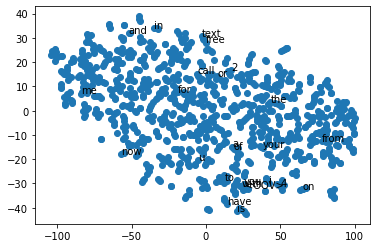

In [42]:
fix, ax = plt.subplots()
ax.scatter(embeddingTSNE5[:,0], embeddingTSNE5[:,1])

for key, i in word_index.items():
    if i <= 25:
        ax.annotate(key, (embeddingTSNE5[i-1,0], embeddingTSNE5[i-1,1]))
#Interessant de voir qu'il n'y a pas vraiment de structure géométrique qui resort
#PAR CONTRE : peut être que des mots proches correspondent à des mots liés à la classification

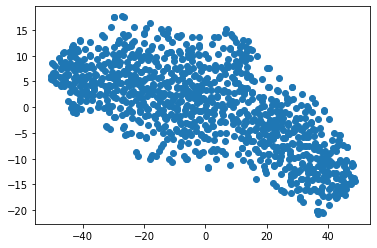

In [28]:
plt.scatter(embeddingTSNE30[:,0], embeddingTSNE30[:,1])

## Add colors for each word
My simplest idea so far : For each sentence, add to each word present in the sentence the prediction confidence of our model on the sentence. Then do an average to rescale at [0,1]. This gives an idea of the "expected confidence" when the word is present in the sentence.
Close to 0 : means we predict ham confidently. Close to 1 : Predict spam confidently.

In [45]:
#vocab_size = 1000
word_confidence = np.zeros((vocab_size, 2))

confidence_train = CNN2.predict(training_padded, batch_size=32) #Much much faster than observation by observatio
L = training_padded.shape[0]
for i in range(L):
    for token in training_padded[i]:
        word_confidence[token, 0] += confidence_train[i]
        word_confidence[token, 1] += 1
            
confidence_test = CNN2.predict(testing_padded, batch_size=32)
L = testing_padded.shape[0]
for i in range(L):
    for token in testing_padded[i]:
        word_confidence[token, 0] += confidence_test[i]
        word_confidence[token, 1] += 1

In [46]:
word_color = np.zeros(vocab_size)
for i in range(vocab_size):
    if word_confidence[i, 1] == 0.0:
        print("Should never happen")
        word_color[i] = 0.5 #Neutral
    else:
        word_color[i] = word_confidence[i,0] / word_confidence[i,1]
print(word_color.shape)

(1000,)


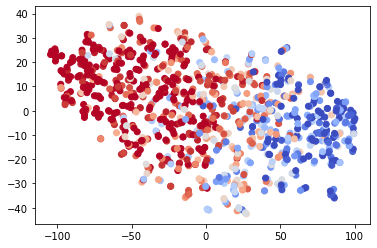

In [31]:
plt.scatter(embeddingTSNE5[:,0], embeddingTSNE5[:,1], c=word_color, cmap='coolwarm')
#coolwarm colormap : red = 1 (spam), blue = 0 (ham)
plt.show()

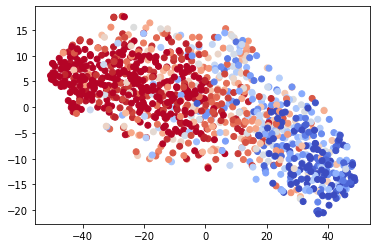

In [32]:
plt.scatter(embeddingTSNE30[:,0], embeddingTSNE30[:,1], c=word_color, cmap='coolwarm')
plt.show()

# Observations about tSNE plots and color
We can observe a clear division between the words most commonly associated with spam (deep red) and the ones associated with non-spam (blue) 

In [48]:
word_color[1] #First word is <OOV> = out of vocabulary token
                #As expected, fairly neutral

0.576982871993988

In [54]:
[w for w,v in word_index.items() if v < vocab_size and word_color[v] == 1.0] #Strongly associated with spam

['prize',
 '£',
 '150p',
 'won',
 '000',
 '£1',
 'valid',
 'weekly',
 '150',
 'cs',
 '150ppm',
 '500',
 '8007',
 'national',
 'mob',
 'awarded',
 'sae',
 'bonus',
 'unsubscribe',
 'poly',
 '£1000',
 'entry',
 'dating',
 '08000930705',
 '800',
 'ltd',
 '£500',
 '86688',
 'expires',
 'reward',
 'camcorder',
 'mobileupd8',
 '£2',
 'winner',
 '£2000',
 '08000839402',
 'ppm',
 'quiz',
 'operator',
 'suite342',
 '2lands',
 'rental',
 'charged',
 'standard',
 '03',
 'ipod',
 'wap',
 'unredeemed',
 '1000',
 '04',
 'txts',
 'dogging',
 '2004',
 'vouchers',
 'savamob',
 '00',
 '87066',
 'charity',
 '£3',
 "c's",
 "uk's",
 '£250',
 'specially',
 'call2optout',
 'awaits',
 '08712460324',
 'w1j6hl',
 '250',
 'pobox',
 '87077',
 "week's",
 '3030',
 'upgrade',
 'maximize',
 'ldew',
 'logo',
 '08718720201',
 'hg',
 'credits',
 'custcare',
 '50p',
 'getzed',
 '£10',
 'horny',
 '£350',
 'ntt',
 '2optout',
 'tenerife',
 '62468',
 'subscription',
 '£5000',
 '28',
 'comuk',
 'reveal',
 '08712300220',
 'opt

# Creating my own message

In [78]:
print(messages['message'][0])
print(type(messages['message'][0]))
print(type(messages))
print(type(messages['message']))

print(type(train_msg))
print(train_msg[0])
print(type(train_msg[0]))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
<class 'str'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
<class 'str'>


In [97]:
new_sentences = ["Are you free tonight ? I'd like to talk to you",
                'I honestly hate dating so much but my parents are pressuring me so much',
                'Dude do you also receive messages saying you won some amazing prize ?',
                "I could never spend £150 on a shirt bro",
                "Nobel Prizes are awarded in the fields of Physics, Chemistry, Physiology or Medicine, Literature, and Peace",
                "Congratulations ! You have won an amazing prize"]

In [98]:
new_sentences2 = pd.Series(new_sentences)

In [99]:
new_sequences = tokenizer.texts_to_sequences(new_sentences2)
print(new_sequences)
print("\n")
new_padded = pad_sequences (new_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)
print(new_padded[0])

[[27, 3, 13, 373, 1, 82, 2, 336, 2, 3], [6, 1, 1, 266, 44, 234, 59, 32, 1, 27, 1, 23, 44, 234], [1, 41, 3, 322, 127, 227, 1, 3, 73, 215, 953, 40], [6, 309, 571, 1, 943, 16, 4, 1, 1], [1, 1, 27, 224, 15, 5, 1, 17, 1, 1, 1, 18, 1, 1, 9, 1], [297, 3, 19, 73, 108, 953, 40]]


[ 27   3  13 373   1  82   2 336   2   3   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [100]:
new_predict = CNN2.predict(new_padded, batch_size=32)
print(new_predict)

[[9.54465210e-01]
 [1.41684711e-12]
 [1.00000000e+00]
 [3.20327341e-11]
 [1.47318915e-05]
 [1.00000000e+00]]


# Observations from these
It's surprisingly hard to trick the model into thinking it's spam

There's a LOT of common words the model simply doesn't have. As a result, it replaces those with the <OOV> token. I suspect that it's because the spelling found in SMS is not great and that the dataset dates from around 2006, when texting on phone wasn't a common practice to COMMUNICATE (therefore, most messages were about meeting at a place, ...)

In [109]:
youtube_messages = pd.read_csv("C:/Users/thinh/DeepLearning/YoutubeSpamCollection/Youtube01-Psy.csv",
                               sep =',', names=["CommentID", "Author", "Date", "message", "label"])
youtube_messages = youtube_messages[1:] # First row is for the labels in the .csv files

In [110]:
youtube_messages['message']

1      Huh, anyway check out this you[tube] channel: ...
2      Hey guys check out my new channel and our firs...
3                 just for test I have to say murdev.com
4       me shaking my sexy ass on my channel enjoy ^_^ ﻿
5                watch?v=vtaRGgvGtWQ   Check this out .﻿
                             ...                        
346    How can this have 2 billion views when there's...
347           I don't now why I'm watching this in 2014﻿
348    subscribe to me for call of duty vids and give...
349    hi guys please my android photo editor downloa...
350    The first billion viewed this because they tho...
Name: message, Length: 350, dtype: object

In [111]:
youtube_sequences = tokenizer.texts_to_sequences(youtube_messages['message'])
youtube_padded = pad_sequences(youtube_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

In [112]:
youtube_padded[0]

array([  1, 798, 454,  57,  29,   3,   1,   1,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [113]:
youtube_predict = CNN2.predict(youtube_padded, batch_size=32)

In [153]:
youtube_predict2 = [round(youtube_predict[i].item()) for i in range(len(youtube_predict))]
youtube_labels = (youtube_messages['label'].map({'0': 0, '1': 1})).values

In [155]:
tn, fp, fn, tp = confusion_matrix(youtube_labels,
                                 youtube_predict2).ravel()

In [157]:
print(tn, fp, fn, tp) #Lots of false negatives : negative = model predicts 0 when it's actually spam

159 16 121 54


In [166]:
youtube_messages[['message', 'label']][150:160] #2 brackets

,message,label
151,Oppa! Yeah! Best Song!﻿,0
152,More... http://www.sunfrogshirts.com/Sunglass-...,1
153,https://www.facebook.com/teeLaLaLa﻿,1
154,http://www.twitch.tv/zxlightsoutxz﻿,1
155,reminds me of this song https://soundcloud.com...,1
156,What free gift cards? Go here http://www.swag...,1
157,"Search ""Chubbz Dinero - Ready Or Not "" Thanks ﻿",1
158,Follow me on Twitter @mscalifornia95﻿,1
159,😫😓😏😪😔😖😌😭😎😚😘😙😗😋😝😜😛😍😒😞😷😶😵😳😲😱😟😰😩😨😧😦😥😤😣😮😴😢😡😠😬😕😑😐😯😉...,0
160,▬▬▬▬▬▬▬▬▬▬ஜ۩۞۩ஜ▬▬▬▬▬▬▬▬ ＤＡＭＮ ＴＨＩＳ ＣＯＭＭＥＮＴ ＩＳ Ｆ...,0


# Trying to understand why it doesn't work great on youtube dataset
I would say :
- Lack of vocabulary (lots of words being projected onto <OOV> token)
- Lacks the detection of **youtube spam** features. Spam emails tend to be about how you "won" something and that you need to call a number, whereas spam on youtube seems to be about checking out someone's channel or clicking on a link